In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

import warnings
warnings.filterwarnings('ignore')

In [2]:
data_path = "/Users/praneetgogoi/Documents/brain-mri-model/brain-mri/train"

image_paths = []
labels_list = []

for class_name in os.listdir(data_path):
    class_path = os.path.join(data_path, class_name)
    if not os.path.isdir(class_path):
        continue
    
    for img_file in os.listdir(class_path):
        if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(class_path, img_file))
            labels_list.append(class_name)

df = pd.DataFrame({'image_path': image_paths, 'label': labels_list})

print(f"Total Images: {len(df)}")
print(f"Number of Classes: {df['label'].nunique()}")
print("\nClass Distribution:")
class_dist = df['label'].value_counts()
print(class_dist)

Total Images: 1400
Number of Classes: 5

Class Distribution:
label
fukuyama_muscular_dystrophy         280
pachygyria_cerebellar_hypoplasia    280
walker_warburg_syndrome             280
moyamoya_disease                    280
hallervorden_spatz_disease          280
Name: count, dtype: int64


In [4]:
from sklearn.model_selection import train_test_split
strat = df['label']
train_df , temp_df = train_test_split(
    df, 
    train_size=0.8, 
    shuffle=True, 
    random_state=42, 
    stratify=strat
)

strat = temp_df['label']
val_df, test_df = train_test_split(
    temp_df, 
    train_size=0.5, 
    shuffle=True, 
    random_state=42, 
    stratify=strat
)

print(f"\nTraining Set: {train_df.shape[0]} images")
print(f"Validation Set: {val_df.shape[0]} images")
print(f"Test Set: {test_df.shape[0]} images")


Training Set: 1120 images
Validation Set: 140 images
Test Set: 140 images


In [5]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_generator = test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image_path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

class_indices = train_generator.class_indices
class_names = list(class_indices.keys())
num_classes = len(class_names)

print(f"\nNumber of classes: {num_classes}")
print(f"Class names: {class_names}")

Found 1120 validated image filenames belonging to 5 classes.
Found 140 validated image filenames belonging to 5 classes.
Found 140 validated image filenames belonging to 5 classes.

Number of classes: 5
Class names: ['fukuyama_muscular_dystrophy', 'hallervorden_spatz_disease', 'moyamoya_disease', 'pachygyria_cerebellar_hypoplasia', 'walker_warburg_syndrome']


In [6]:
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3),
    pooling='avg'
)

base_model.trainable = True

for layer in base_model.layers[:100]: 
    layer.trainable = False
for layer in base_model.layers[100:]: 
    layer.trainable = True

x = base_model.output
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"\nModel Summary:")
model.summary()


Model Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,625,605 (10.02 MB)

 Trainable params: 2,225,989 (8.49 MB)

 Non-trainable params: 399,616 (1.52 MB)

In [7]:
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        mode='max'
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        'best_mobilenetv2_tf_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max'
    )
]

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=callbacks,
    verbose=1
)


val_loss, val_accuracy = model.evaluate(val_generator, verbose=0)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.3047 - loss: 1.8024

35/35 ━━━━━━━━━━━━━━━━━━━━ 14s 237ms/step - accuracy: 0.4036 - loss: 1.5287 - val_accuracy: 0.4357 - val_loss: 1.2555 - learning_rate: 1.0000e-04
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.6803 - loss: 0.8663

35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 222ms/step - accuracy: 0.6929 - loss: 0.8271 - val_accuracy: 0.6143 - val_loss: 0.9003 - learning_rate: 1.0000e-04
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.8146 - loss: 0.5337

35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 228ms/step - accuracy: 0.8188 - loss: 0.5182 - val_accuracy: 0.6714 - val_loss: 0.8160 - learning_rate: 1.0000e-04
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 228ms/step - accuracy: 0.9009 - loss: 0.3478 - val_accuracy: 0.6643 - val_loss: 0.8050 - learning_rate: 1.0000e-04
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.8986 - loss: 0.3281

35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 234ms/step - accuracy: 0.8857 - loss: 0.3424 - val_accuracy: 0.7000 - val_loss: 0.7568 - learning_rate: 1.0000e-04
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.9092 - loss: 0.2877

35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 239ms/step - accuracy: 0.9196 - loss: 0.2596 - val_accuracy: 0.7286 - val_loss: 0.6199 - learning_rate: 1.0000e-04
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.9506 - loss: 0.1735

35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 237ms/step - accuracy: 0.9491 - loss: 0.1779 - val_accuracy: 0.7429 - val_loss: 0.5671 - learning_rate: 1.0000e-04
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 234ms/step - accuracy: 0.9509 - loss: 0.1651 - val_accuracy: 0.7286 - val_loss: 0.6380 - learning_rate: 1.0000e-04
Epoch 9/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.9629 - loss: 0.1366

35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 238ms/step - accuracy: 0.9661 - loss: 0.1253 - val_accuracy: 0.7500 - val_loss: 0.5964 - learning_rate: 1.0000e-04
Epoch 10/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.9577 - loss: 0.1180

35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 241ms/step - accuracy: 0.9643 - loss: 0.1186 - val_accuracy: 0.8214 - val_loss: 0.4345 - learning_rate: 1.0000e-04
Epoch 11/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 242ms/step - accuracy: 0.9848 - loss: 0.0873 - val_accuracy: 0.8000 - val_loss: 0.4661 - learning_rate: 1.0000e-04
Epoch 12/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 247ms/step - accuracy: 0.9857 - loss: 0.0735 - val_accuracy: 0.8071 - val_loss: 0.4146 - learning_rate: 1.0000e-04
Epoch 13/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9805 - loss: 0.0772

35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 249ms/step - accuracy: 0.9821 - loss: 0.0723 - val_accuracy: 0.8643 - val_loss: 0.2888 - learning_rate: 1.0000e-04
Epoch 14/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 248ms/step - accuracy: 0.9830 - loss: 0.0586 - val_accuracy: 0.8643 - val_loss: 0.3204 - learning_rate: 1.0000e-04
Epoch 15/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.9922 - loss: 0.0497

35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 253ms/step - accuracy: 0.9866 - loss: 0.0577 - val_accuracy: 0.9000 - val_loss: 0.2348 - learning_rate: 1.0000e-04
Epoch 16/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 261ms/step - accuracy: 0.9893 - loss: 0.0486 - val_accuracy: 0.8786 - val_loss: 0.3048 - learning_rate: 1.0000e-04
Epoch 17/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.9877 - loss: 0.0408

35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 282ms/step - accuracy: 0.9884 - loss: 0.0418 - val_accuracy: 0.9286 - val_loss: 0.1628 - learning_rate: 1.0000e-04
Epoch 18/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 280ms/step - accuracy: 0.9875 - loss: 0.0461 - val_accuracy: 0.9214 - val_loss: 0.1726 - learning_rate: 1.0000e-04
Epoch 19/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.9934 - loss: 0.0333

35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 306ms/step - accuracy: 0.9946 - loss: 0.0322 - val_accuracy: 0.9643 - val_loss: 0.1218 - learning_rate: 1.0000e-04
Epoch 20/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.9955 - loss: 0.0295

35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 310ms/step - accuracy: 0.9964 - loss: 0.0269 - val_accuracy: 0.9714 - val_loss: 0.1009 - learning_rate: 1.0000e-04
Epoch 21/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.9945 - loss: 0.0244

35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 306ms/step - accuracy: 0.9920 - loss: 0.0297 - val_accuracy: 0.9786 - val_loss: 0.0890 - learning_rate: 1.0000e-04
Epoch 22/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 320ms/step - accuracy: 0.9911 - loss: 0.0338 - val_accuracy: 0.9786 - val_loss: 0.0742 - learning_rate: 1.0000e-04
Epoch 23/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 12s 338ms/step - accuracy: 0.9830 - loss: 0.0480 - val_accuracy: 0.9643 - val_loss: 0.1169 - learning_rate: 1.0000e-04
Epoch 24/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 12s 346ms/step - accuracy: 0.9848 - loss: 0.0472 - val_accuracy: 0.9714 - val_loss: 0.0678 - learning_rate: 1.0000e-04
Epoch 25/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 374ms/step - accuracy: 0.9866 - loss: 0.0367 - val_accuracy: 0.9571 - val_loss: 0.1231 - learning_rate: 1.0000e-04
Epoch 26/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 12s 337ms/step - accuracy: 0.9955 - loss: 0.0214 - val_accuracy: 0.9714 - val_loss: 0.0893 - learning_rate: 1.0000e-04
Epoch 27/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 373ms/step - accuracy

35/35 ━━━━━━━━━━━━━━━━━━━━ 12s 336ms/step - accuracy: 0.9955 - loss: 0.0178 - val_accuracy: 0.9857 - val_loss: 0.0552 - learning_rate: 1.0000e-04
Epoch 31/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 12s 326ms/step - accuracy: 0.9955 - loss: 0.0163 - val_accuracy: 0.9643 - val_loss: 0.1015 - learning_rate: 1.0000e-04
Epoch 32/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 12s 326ms/step - accuracy: 0.9973 - loss: 0.0145 - val_accuracy: 0.9643 - val_loss: 0.1018 - learning_rate: 1.0000e-04
Epoch 33/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 12s 337ms/step - accuracy: 0.9911 - loss: 0.0213 - val_accuracy: 0.9643 - val_loss: 0.1350 - learning_rate: 1.0000e-04
Epoch 34/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.9946 - loss: 0.0190

35/35 ━━━━━━━━━━━━━━━━━━━━ 12s 335ms/step - accuracy: 0.9911 - loss: 0.0292 - val_accuracy: 0.9929 - val_loss: 0.0308 - learning_rate: 1.0000e-04
Epoch 35/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 12s 331ms/step - accuracy: 0.9964 - loss: 0.0192 - val_accuracy: 0.9857 - val_loss: 0.0454 - learning_rate: 1.0000e-04
Epoch 36/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 320ms/step - accuracy: 0.9964 - loss: 0.0155 - val_accuracy: 0.9786 - val_loss: 0.0745 - learning_rate: 1.0000e-04
Epoch 37/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 367ms/step - accuracy: 0.9946 - loss: 0.0209 - val_accuracy: 0.9643 - val_loss: 0.0975 - learning_rate: 1.0000e-04
Epoch 38/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 12s 343ms/step - accuracy: 0.9991 - loss: 0.0106 - val_accuracy: 0.9714 - val_loss: 0.0612 - learning_rate: 1.0000e-04
Epoch 39/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.9949 - loss: 0.0135
Epoch 39: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
35/35 ━━━━━━━━━━━━━━━━━━━━ 12s 336ms/step - accuracy: 0.99

In [8]:
from sklearn.metrics import classification_report, confusion_matrix
test_generator.reset()
predictions = model.predict(test_generator, verbose=0)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_names))



Classification Report:
                                  precision    recall  f1-score   support

     fukuyama_muscular_dystrophy       1.00      1.00      1.00        28
      hallervorden_spatz_disease       0.97      1.00      0.98        28
                moyamoya_disease       1.00      0.96      0.98        28
pachygyria_cerebellar_hypoplasia       1.00      1.00      1.00        28
         walker_warburg_syndrome       1.00      1.00      1.00        28

                        accuracy                           0.99       140
                       macro avg       0.99      0.99      0.99       140
                    weighted avg       0.99      0.99      0.99       140



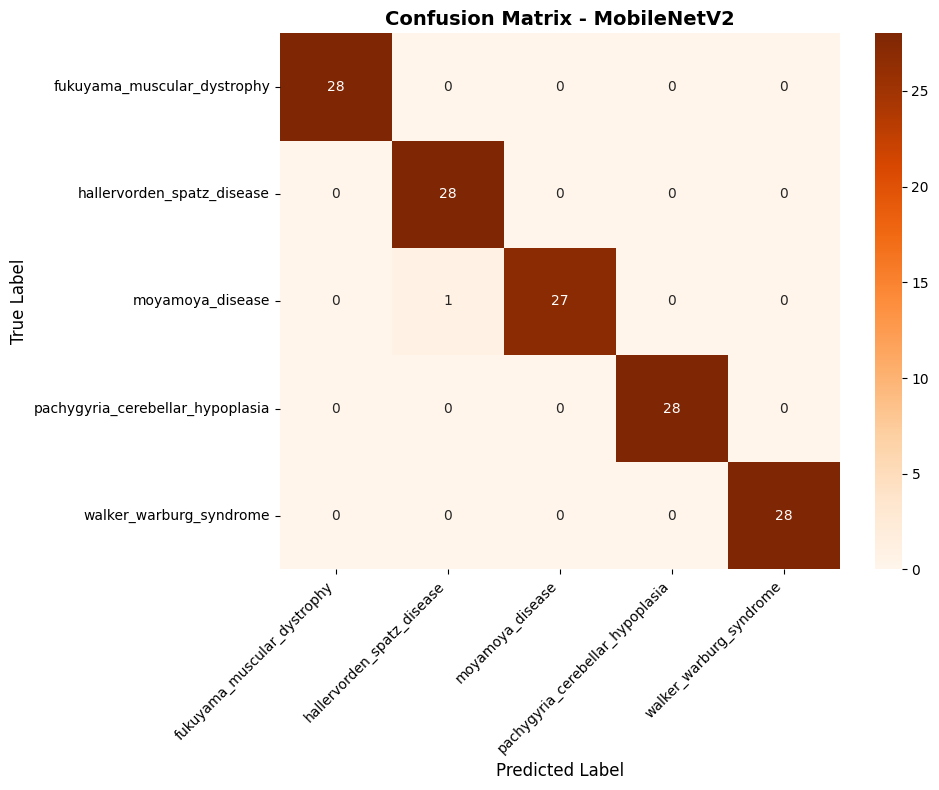

In [9]:
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - MobileNetV2', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('mobilenetv2_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

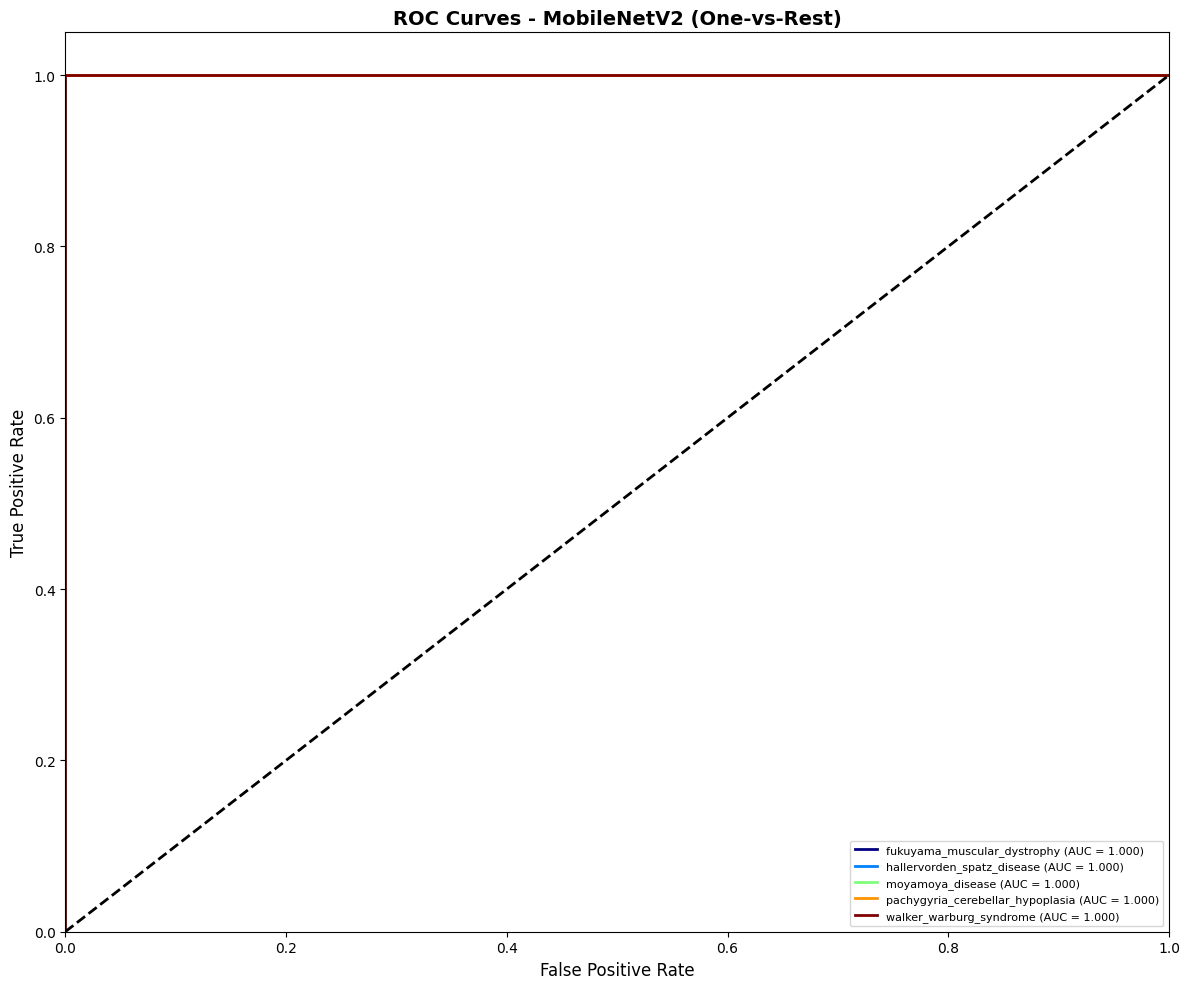

In [10]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
y_true_bin = label_binarize(true_classes, classes=list(range(num_classes)))
y_score = predictions

plt.figure(figsize=(12, 10))
colors = plt.cm.jet(np.linspace(0, 1, num_classes))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], lw=2,
             label=f'{class_names[i]} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - MobileNetV2 (One-vs-Rest)', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=8)
plt.tight_layout()
plt.savefig('mobilenetv2_roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

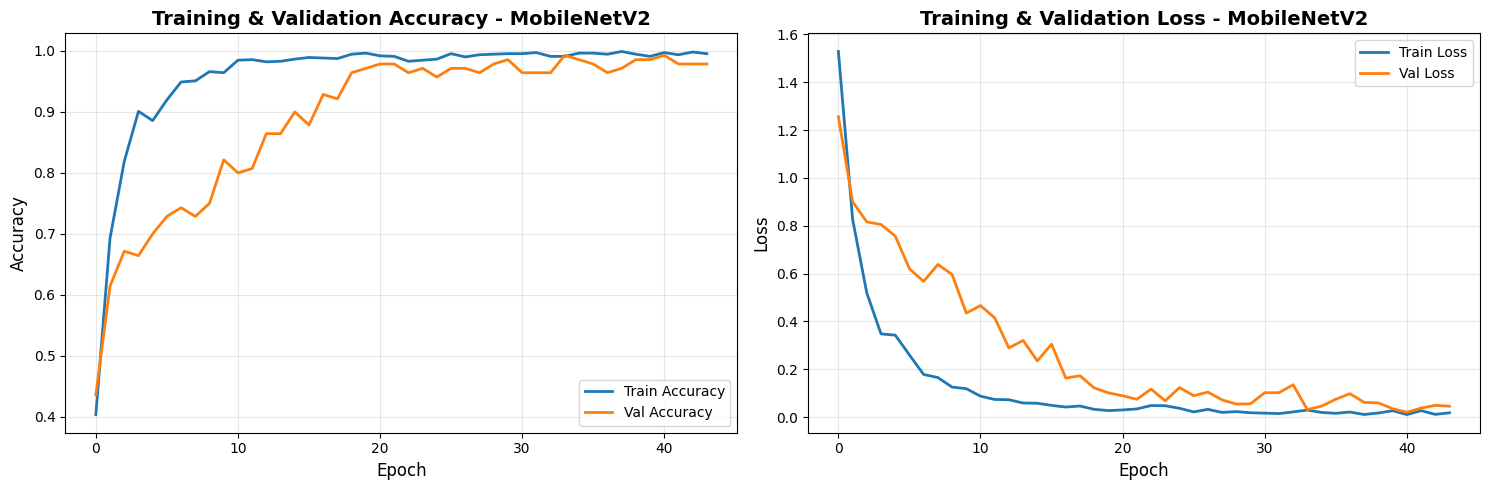

In [11]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Training & Validation Accuracy - MobileNetV2', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training & Validation Loss - MobileNetV2', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('mobilenetv2_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

In [12]:
model.save('mobilenetv2.h5')
print("\nModel saved as 'mobilenetv2.h5'")
print("Best model weights saved as 'best_mobilenetv2_tf_model.h5'")

print("\n" + "="*50)
print("MobileNetV2 Model Training Complete!")
print("="*50)


Model saved as 'mobilenetv2.h5'
Best model weights saved as 'best_mobilenetv2_tf_model.h5'

MobileNetV2 Model Training Complete!
